In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import copy

### backup old class


```python
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.train = train

        self.empty_imgs = list((self.img_dir / "empty").glob("*"))
        self.occupied_imgs = list((self.img_dir / "occupied").glob("*"))
        self.all_imgs = self.empty_imgs + self.occupied_imgs
        random.shuffle(self.all_imgs)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_path = self.all_imgs[idx]
        img = read_image(str(img_path)).float() / 255.0
        # img = torch.mean(img, dim=0, keepdim=True)  # Convert to grayscale

        label = 0 if "empty" in img_path.parts else 1

        if self.transform:
            img = self.transform(img)

        return img, label
    # add a func to return the file name
    def get_file_name(self, idx):
        img_path = self.all_imgs[idx]
        return img_path.parts[-1]
```

In [2]:
import random
from torch.utils.data import Dataset, random_split
from torchvision.io import read_image
from pathlib import Path

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True, augment_minority=True, minority_multiplier=int(2000/460)+1):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.train = train
        self.augment_minority = augment_minority
        self.minority_multiplier = minority_multiplier

        self.empty_imgs = list((self.img_dir / "empty").glob("*"))
        self.occupied_imgs = list((self.img_dir / "occupied").glob("*"))

        # balance datasets
        if self.augment_minority and self.train:
            self.empty_imgs = self.empty_imgs * self.minority_multiplier


        self.all_imgs = self.empty_imgs + self.occupied_imgs
        random.shuffle(self.all_imgs)

        # if self.augment_minority:
        #     self.minority_augmentation = transforms.Compose([
        #         transforms.RandomHorizontalFlip(p=0.5),
        #         transforms.RandomRotation(degrees=20),
        #     ])


    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_path = self.all_imgs[idx]
        img = read_image(str(img_path)).float() / 255.0
        # img = torch.mean(img, dim=0, keepdim=True)  # Convert to grayscale

        label = 0 if "empty" in img_path.parts else 1

        if self.transform:
            img = self.transform(img)

        # if self.augment_minority and self.train and label == 0:
        #     img = self.minority_augmentation(img)

        return img, label
    # add a func to return the file name
    def get_file_name(self, idx):
        img_path = self.all_imgs[idx]
        return img_path.parts[-1]

# Apply transformations, resize it to 224x224

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]),
    ]),
    'val': transforms.Compose([
    # transforms.RandomRotation(degrees=20),
    transforms.Resize((224,224)),
    # transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]),
    ]),
}



In [13]:
# Create custom dataset
full_dataset = CustomDataset('/home/fanqy/research-temp/eee5015/mid-proj/normalized_datasets')
print("Number of empty images:", len(full_dataset.empty_imgs))
print("Number of occupied images:", len(full_dataset.occupied_imgs))
print("Total images:", len(full_dataset))

# Calculate the lengths of the train, validation, and test sets
train_len = int(0.75 * len(full_dataset))
val_len = int(0.2 * len(full_dataset))
test_len = len(full_dataset) - train_len - val_len

# Split the dataset
train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

train_set.dataset.transform = data_transforms['train']
val_set.dataset.transform = data_transforms['val']
test_set.dataset.transform = data_transforms['val']

# Create data loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

# Update data loaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': train_len, 'val': val_len}
class_names = ['empty', 'occupied']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of empty images: 2300
Number of occupied images: 2000
Total images: 4300


In [ ]:
for i in range(2000):
    print(full_dataset.get_file_name(i))
    print(full_dataset[i][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


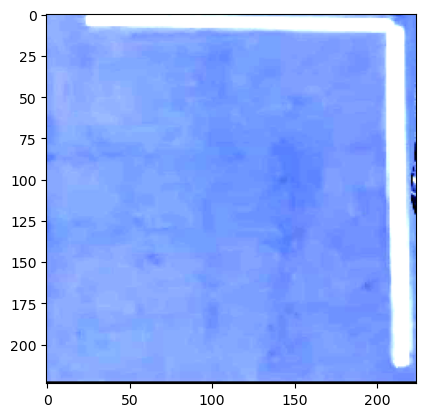

In [6]:
# plot some fig from train set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
imshow(val_set[102][0])

In [5]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        # only need 2 classes
        self.fc16 = nn.Linear(4096, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [6]:
model = VGG16_NET()
model.to(device)

VGG16_NET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3,

In [7]:
# my custom model

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()

        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        value = self.value(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x

class CustomCNNWithAttention(nn.Module):
    def __init__(self):
        super(CustomCNNWithAttention, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.avgpool = nn.AdaptiveAvgPool2d((16, 16))

        self.attention = SelfAttention(in_channels=128)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.avgpool(x)
        x = self.attention(x)

        x = x.view(-1, 128 * 16 * 16)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        output = F.softmax(x, dim=1)
        return output

model = CustomCNNWithAttention()
model = model.to(device)
print(model)


CustomCNNWithAttention(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(16, 16))
  (attention): SelfAttention(
    (query): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [42]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     best_model_wts = model.state_dict()
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 scheduler.step()
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = model.state_dict()

#         print()

#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

# model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # print(inputs.shape)
                # print(labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print current epoch loss and accuracy
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model)

    return model, best_model_wts



## Train

In [17]:
model, best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
train Loss: 0.3704 Acc: 0.9436
val Loss: 0.3767 Acc: 0.9360
Epoch 1/99
train Loss: 0.3645 Acc: 0.9482
val Loss: 0.3564 Acc: 0.9570
Epoch 2/99
train Loss: 0.3562 Acc: 0.9557
val Loss: 0.3509 Acc: 0.9640
Epoch 3/99
train Loss: 0.3509 Acc: 0.9622
val Loss: 0.3878 Acc: 0.9198
Epoch 4/99
train Loss: 0.3500 Acc: 0.9637
val Loss: 0.3586 Acc: 0.9477
Epoch 5/99
train Loss: 0.3561 Acc: 0.9560
val Loss: 0.3634 Acc: 0.9512
Epoch 6/99
train Loss: 0.3432 Acc: 0.9715
val Loss: 0.3456 Acc: 0.9674
Epoch 7/99
train Loss: 0.3418 Acc: 0.9733
val Loss: 0.3450 Acc: 0.9686
Epoch 8/99
train Loss: 0.3410 Acc: 0.9740
val Loss: 0.3446 Acc: 0.9709
Epoch 9/99
train Loss: 0.3404 Acc: 0.9740
val Loss: 0.3444 Acc: 0.9721
Epoch 10/99
train Loss: 0.3390 Acc: 0.9774
val Loss: 0.3436 Acc: 0.9709
Epoch 11/99
train Loss: 0.3407 Acc: 0.9730
val Loss: 0.3435 Acc: 0.9721
Epoch 12/99
train Loss: 0.3390 Acc: 0.9755
val Loss: 0.3434 Acc: 0.9721
Epoch 13/99
train Loss: 0.3390 Acc: 0.9755
val Loss: 0.3431 Acc: 0.9721
Ep

In [19]:
# save best_model
torch.save(best_model, 'trained_models/custom-cnn-w-attention/best_model_100epoch_64batch_97pct.pth')

In [18]:
# load model 
# best_model = torch.load('trained_models/custom-cnn-w-attention/best_model_30epoch_94pct.pth')
# evaluate model using test set
model = best_model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 97 %


In [20]:
from torchinfo import summary
summary(model, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNNWithAttention                   [64, 2]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─MaxPool2d: 1-2                         [64, 32, 112, 112]        --
├─Conv2d: 1-3                            [64, 64, 112, 112]        18,496
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Conv2d: 1-5                            [64, 128, 56, 56]         73,856
├─MaxPool2d: 1-6                         [64, 128, 28, 28]         --
├─AdaptiveAvgPool2d: 1-7                 [64, 128, 16, 16]         --
├─SelfAttention: 1-8                     [64, 128, 16, 16]         1
│    └─Conv2d: 2-1                       [64, 16, 16, 16]          2,064
│    └─Conv2d: 2-2                       [64, 16, 16, 16]          2,064
│    └─Conv2d: 2-3                       [64, 128, 16, 16]         16,512
├─Linear: 1-9                            [64, 256]                 

In [17]:
# test single image (incomplete)
import cv2
from PIL import Image
model = best_model
model.eval()
img = "/home/fanqy/research-temp/eee5015/mid-proj/normalized_datasets/occupied/o970.png"
img = read_image(img).float()/255.0
img = data_transforms["train"](img)
img_batch = torch.stack([img] * 64)
print(img_batch.shape)





# imshow(img)
img = img.to(device)
outputs = model(img)
# _, predicted = torch.max(outputs.data, 1)
# print(predicted)




torch.Size([64, 3, 224, 224])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x49 and 25088x4096)